In [ ]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

In [ ]:
def get_coverage(res, true, confidence=.95):
    point = res[:, 0]
    stderr = res[:, 1]
    zstat = scipy.stats.norm.ppf((1 + confidence) / 2.)
    lb = point - zstat * stderr
    ub = point + zstat * stderr
    cov = (true >= lb) & (true <= ub)
    return np.mean(cov)

def get_bias(res, true):
    return np.abs(np.mean(res[:, 0]) - true)

def get_std(res, true):
    return np.std(res[:, 0])

def get_mean_stderr(res, true):
    return np.mean(res[:, 1])

# Nested regression estimation

We first just look at estimation of dynamic treatment effects in simple SNMMs where the effect is not state dependent and hence invariant across contexts. We start by simple nested regression approaches that are not Neyman orthogonal.

In [ ]:
n = 1000
S = np.random.normal(0, 1, size=(n, 5)) # initial state
T1 = np.random.binomial(1, scipy.special.expit(S[:, 0]))
X = T1.reshape(-1, 1) + S + np.random.normal(0, 1, size=(n, 5)) # second period state
T2 = np.random.binomial(1, scipy.special.expit(X[:, 0]))
y = T2 + X[:, 0] + np.random.normal(0, 1, size=(n,))

#### Wrong variants

None of the regressions below estimate the correct dynamic treatment effects

In [ ]:
# y ~ T1, T2; does not control for anything
LinearRegression().fit(np.hstack([T1.reshape(-1, 1), T2.reshape(-1, 1)]), y).coef_

array([1.39705303, 2.45322147])

In [ ]:
# y ~ T1, T2, X; controls only for second period state and shuts down the effect of T1
LinearRegression().fit(np.hstack([T1.reshape(-1, 1), T2.reshape(-1, 1), X]), y).coef_[:2]

array([0.04195985, 1.09733368])

In [ ]:
# y ~ T1, T2, S; controls only for first period state and does not remove confounding
# due to second period state X
LinearRegression().fit(np.hstack([T1.reshape(-1, 1), T2.reshape(-1, 1), S]), y).coef_[:2]

array([0.92383732, 1.96513965])

#### Correct variant

The correct approach is to do a nested regression where we adjust the ouctome after the first regression, i.e.
\begin{align}
y \sim~& T2, X\\
y - \theta_2 T_2 \sim~& T1, S
\end{align}

In [ ]:
lr2 = LinearRegression().fit(np.hstack([T2.reshape(-1, 1), X]), y)
yadj = y - lr2.coef_[0] * T2
lr1 = LinearRegression().fit(np.hstack([T1.reshape(-1, 1), S]), yadj)
print(lr1.coef_[:1], lr2.coef_[:1])

[1.08415341] [1.09895102]


# G estimation

Now we also introduce the G-estimation variant that estimates propensities and does not model how the outcomes depend on states. In particular, we solve recursively the moment equations:
\begin{align}
E[(y - \theta_2 T_2)\, (T_2 - E[T_2|X])] =~& 0\\
E[(y - \theta_2 T_2 - \theta_1 T_1)\, (T_1 - E[T_1|S])] =~& 0\\
\end{align}

In [ ]:
lg2 = LogisticRegression().fit(X, T2)
T2res = T2 - lg2.predict_proba(X)[:, 1]
theta2 = np.mean(y*T2res) / np.mean(T2 * T2res)
lg1 = LogisticRegression().fit(S, T1)
T1res = T1 - lg1.predict_proba(S)[:, 1]
theta1 = np.mean((y - theta2*T2) * T1res) / np.mean(T1 * T1res)
print(theta1, theta2)

1.0942761124246583 1.1087823395603011


# Debiased G estimation

The Debiased G estimation combines both approaches. It solves the moment conditions:
\begin{align}
E[(y - E[y|X] - \theta_2 (T_2 - E[T_2|X]))\, (T_2 - E[T_2|X])] =~& 0\\
E[(y - \theta_2 T_2 - E[y - \theta_2 T_2|S] - \theta_1 (T_1-E[T_1|S]))\, (T_1 - E[T_1|S])] =~& 0\\
\end{align}

In [ ]:
lr2 = LinearRegression().fit(X, y)
lg2 = LogisticRegression().fit(X, T2)
T2res = T2 - lg2.predict_proba(X)[:, 1]
y2res = y - lr2.predict(X)
theta2 = np.mean(y2res * T2res) / np.mean(T2res * T2res)

yadj = y - theta2*T2
lr1 = LinearRegression().fit(S, yadj)
lg1 = LogisticRegression().fit(S, T1)
T1res = T1 - lg1.predict_proba(S)[:, 1]
y1res = yadj - lr1.predict(S)
theta1 = np.mean(y1res * T1res) / np.mean(T1res * T1res)
print(theta1, theta2)

1.0920713285145867 1.1014085236062103


# OPT DTR

We now move on to estimating dynamic treatment effects under the optimal dynamic policy and also dynamic optimal policy values

### Data Generating Functions

In [ ]:
# Some functions to generate observations

# generate observational data
# mu1 controls the magnitude of the effect of the first period treatment
# mu2 controls the magnitude of the effect of the second period treatment
def gen_obs(n, mu1=1, mu2=1):
    S = np.random.normal(0, 1, size=(n, 5))
    T1 = np.random.binomial(1, scipy.special.expit(S[:, 0]))
    X = mu1 * T1.reshape(-1, 1) + S + np.random.normal(0, 1, size=(n, 5))
    T2 = np.random.binomial(1, scipy.special.expit(X[:, 0]))
    y = mu2 * (X[:, 0] + 1) * T2 + X[:, 0] + np.random.normal(0, 1, size=(n,))
    return S, T1, X, T2, y

# generate data under two period policies pi1, pi2
def gen_pi(n, pi1, pi2, mu1=1, mu2=1):
    S = np.random.normal(0, 1, size=(n, 5))
    T1 = pi1(S)
    X = mu1 * T1.reshape(-1, 1) + S + np.random.normal(0, 1, size=(n, 5))
    T2 = pi2(X)
    y = mu2 * (X[:, 0] + 1) * T2  + X[:, 0] + np.random.normal(0, 1, size=(n,))
    return S, T1, X, T2, y

# generate data under the optimal dynamic policy
def gen_opt(n, mu1=1, mu2=1):
    S = np.random.normal(0, 1, size=(n, 5))
    T1 = 1.0 * (mu1 * mu2 >= 0) * np.ones(n)
    X = mu1 * T1.reshape(-1, 1) + S + np.random.normal(0, 1, size=(n, 5))
    T2 = 1.0 * (mu2 * (X[:, 0] + 1)>= 0)
    y = mu2 * (X[:, 0] + 1) * T2  + X[:, 0] + np.random.normal(0, 1, size=(n,))
    return S, T1, X, T2, y

# generate data under a softmax optimal dynamic policy
def gen_softopt(n, mu1=1, mu2=1, beta=1, mc_samples=1000):
    S = np.random.normal(0, 1, size=(n, 5))

    y1soft = np.zeros((n,))
    y0soft = np.zeros((n,))
    for t in range(mc_samples):
        eps = np.random.normal(0, 1, size=(n, 5))

        X0 = S + eps
        u20 = np.stack((np.zeros(n), mu2 * (X0[:, 0] + 1)), axis=-1)
        T20soft = scipy.special.softmax(beta * u20, axis=1)[:, 1]
        y0soft += (mu2 * (X0[:, 0] + 1) * T20soft + X0[:, 0]) / mc_samples

        X1 = mu1 * 1 + S + eps
        u21 = np.stack((np.zeros(n), mu2 * (X1[:, 0] + 1)), axis=-1)
        T21soft = scipy.special.softmax(beta * u21, axis=1)[:, 1]
        y1soft += (mu2 * (X1[:, 0] + 1) * T21soft + X1[:, 0]) / mc_samples

    u1soft = np.stack((y0soft, y1soft), axis=-1)
    T1soft = scipy.special.softmax(beta * u1soft, axis=1)[:, 1]

    Xsoft = mu1 * T1soft.reshape(-1, 1) + S + np.random.normal(0, 1, size=(n, 5))

    u2soft = np.stack((np.zeros(n), mu2 * (Xsoft[:, 0] + 1)), axis=-1)
    T2soft = scipy.special.softmax(beta * u2soft, axis=1)[:, 1]

    ysoft = mu2 * (Xsoft[:, 0] + 1) * T2soft  + Xsoft[:, 0] + np.random.normal(0, 1, size=(n,))

    return S, T1soft, Xsoft, T2soft, ysoft

### Inference on Optimal Policy via Softmax Approximation

Now we define a function that estimates the structural parameters and the value of the optimal dynamic policy via softmax approximation

In [ ]:
# blip models for the two periods
def phi2(X, T2):
    return np.hstack([T2.reshape(-1, 1), X[:, [0]]*T2.reshape(-1, 1)])
def phi1(X, T1):
    return np.hstack([T1.reshape(-1, 1), X[:, [0]]*T1.reshape(-1, 1)])

def dtr(S, T1, X, T2, y, phi1, phi2, pi1=None, pi2=None, beta=None,
        yreg1=None, treg1=None, yreg2=None, treg2=None):
    '''
    Optimal Dynamic Regime Estimation via Softmax Approximation

    S: first period state
    T1: first period treatment
    X: second period state
    T2: second period treatment
    y: final outcome
    phi1: blip model for first period (S, T1) -> blip features
    phi2: blip model for second period (X, T2) -> blip features
    pi1: fixed first period policy, (optional, default=None)
        if we want to evaluate a fixed target policy and not the optimal policy
    pi1: fixed second period policy, (optional, default=None)
        if we want to evaluate a fixed target policy and not the optimal policy
    beta: the softmax temperature parameter
    yreg1: Regression model for the first period outcome regression
        yadj := y - theta2'phi(X, T2) ~ S
    treg1: Regression model for first period treatment regression T1 ~ S
    yreg2: Regression model for second period outcome regression y ~ X
    treg2: Regression model for second period treatment regression T2 ~ X
    '''

    yreg1 = (lambda: LinearRegression()) if yreg1 is None else yreg1
    treg1 = (lambda: LinearRegression()) if treg1 is None else treg1
    yreg2 = (lambda: LinearRegression()) if yreg2 is None else yreg2
    treg2 = (lambda: LinearRegression()) if treg2 is None else treg2
    n = X.shape[0]

    ####
    # Point Estimation
    ####

    # Last period
    lr2 = yreg2().fit(X, y)
    lg2 = treg2().fit(X, phi2(X, T2))
    T2res = phi2(X, T2) - lg2.predict(X)
    y2res = y - lr2.predict(X)
    eff2 = LinearRegression(fit_intercept=False).fit(T2res, y2res)

    # Counterfactual policy
    if pi2 is None:
        u1 = eff2.predict(phi2(X, np.ones(T2.shape)))
        u0 = eff2.predict(phi2(X, np.zeros(T2.shape)))
        opt = 1.0 * (u1 >= u0)
        if beta is None:
            # Last period optimal policy
            T2new = np.stack((1 - opt, opt), axis=-1)
        else:
            # Last period softmax optimal policy
            u = np.hstack([u0.reshape(-1, 1), u1.reshape(-1, 1)])
            T2new = scipy.special.softmax(beta * u, axis=1)
    else:
        # Fixed policy
        T2new = np.stack((1 - pi2(X), pi2(X)), axis=-1)

    # Adjust outcome for second period treatment
    phi2new = T2new[:, [0]] * phi2(X, np.zeros(T2.shape))
    phi2new += T2new[:, [1]] * phi2(X, np.ones(T2.shape))
    yadj = y - eff2.predict(phi2(X, T2) - phi2new)

    # First period
    lr1 = yreg1().fit(S, yadj)
    lg1 = treg1().fit(S, phi1(S, T1))
    T1res = phi1(S, T1) - lg1.predict(S)
    y1res = yadj - lr1.predict(S)
    eff1 = LinearRegression(fit_intercept=False).fit(T1res, y1res)

    # Counterfactual policy
    if pi1 is None:
        u1 = eff1.predict(phi1(S, np.ones(T1.shape)))
        u0 = eff1.predict(phi1(S, np.zeros(T1.shape)))
        opt = 1.0 * (u1 >= u0)
        if beta is None:
            # First period optimal policy
            T1new = np.stack((1 - opt, opt), axis=-1)
        else:
            # First period softmax optimal policy
            u = np.hstack([u0.reshape(-1, 1), u1.reshape(-1, 1)])
            T1new = scipy.special.softmax(beta * u, axis=1)
    else:
        # Fixed policy
        T1new = np.stack((1 - pi1(S), pi1(S)), axis=-1)

    # Adjust outcome for first period treatment
    phi1new = T1new[:, [0]] * phi1(S, np.zeros(T1.shape))
    phi1new += T1new[:, [1]] * phi1(S, np.ones(T1.shape))
    yadj = yadj - eff1.predict(phi1(S, T1) - phi1new)


    # Parameters
    params = np.append(eff2.coef_, eff1.coef_)

    #Policy value
    value = np.mean(yadj)

    #####
    # Variance calculation
    #####

    # Parameter covariance
    d1, d2 = len(eff1.coef_), len(eff2.coef_)
    J = np.zeros((d1 + d2, d1 + d2))
    J[:d2, :d2] = T2res.T @ T2res / n
    J[d2:, d2:] = T1res.T @ T1res / n
    J[d2:, :d2] = T1res.T @ (phi2(X, T2) - phi2new) / n
    if beta is not None:
        phi2new = T2new[:, [0]] * phi2(X, np.zeros(T2.shape))
        phi2new += T2new[:, [1]] * phi2(X, np.ones(T2.shape))
        Unew = eff2.predict(phi2new)
        U = T2new[:, [0]] * (eff2.predict(phi2(X, np.zeros(T2.shape))) - Unew).reshape(-1, 1) * phi2(X, np.zeros(T2.shape))
        U += T2new[:, [1]] * (eff2.predict(phi2(X, np.ones(T2.shape))) - Unew).reshape(-1, 1) * phi2(X, np.ones(T2.shape))
        U = beta * U
        J[d2:, :d2] += T1res.T @ U / n
    Jinv = np.linalg.pinv(J)
    M = np.zeros((n, d1 + d2))
    M[:, :d2] = (y2res - eff2.predict(T2res)).reshape(-1, 1) * T2res
    M[:, d2:] = (y1res - eff1.predict(T1res)).reshape(-1, 1) * T1res
    Cov = Jinv @ (M.T @ M / n) @ Jinv.T

    # Policy variance
    Q = np.hstack([phi2(X, T2) - phi2new, phi1(S, T1) - phi1new])
    value_var = np.var(yadj) + np.mean(Q, axis=0) @ Cov @ np.mean(Q, axis=0)
    return params, Cov, value, value_var

#### Example estimates for Opt DTR

In [ ]:
n = 1000
mu1, mu2 = 0, 0
params, Cov, value, value_var = dtr(*gen_obs(n, mu1, mu2), phi1, phi2, beta=10)

In [ ]:
params, np.sqrt(np.diag(Cov) / n), value, np.sqrt(value_var / n)

(array([ 0.01499892, -0.05335247, -0.06822617, -0.04156751]),
 array([0.07735197, 0.0541593 , 0.09894422, 0.09578564]),
 0.1532827802533842,
 0.07009272354414799)

In [ ]:
params, np.sqrt(np.diag(Cov) / n), value, np.sqrt(value_var / n)

(array([ 0.01499892, -0.05335247, -0.06822617, -0.04156751]),
 array([0.07735197, 0.0541593 , 0.09894422, 0.09578564]),
 0.1532827802533842,
 0.07009272354414799)

### Coverage experiments

In [ ]:
def exp(it, n, mu1, mu2, phi1, phi2, pi1=None, pi2=None, beta=None, yreg1=None, treg1=None, yreg2=None, treg2=None):
    np.random.seed(it)
    params, Cov, value, value_var = dtr(*gen_obs(n, mu1, mu2), phi1, phi2, pi1, pi2, beta, yreg1, treg1, yreg2, treg2)
    return value, np.sqrt(value_var / n)

#### Opt DTR Coverage

In [ ]:
n = 5000
mu1, mu2 = 0, 0
res = Parallel(n_jobs=-1)(delayed(exp)(it, n, mu1, mu2, phi1, phi2) for it in range(100))

In [ ]:
if mu1 == 0 and mu2 == 0:
    true = 0
else:
    true = np.mean(gen_opt(10000, mu1, mu2)[4])
print(true)

0


In [ ]:
print(get_coverage(np.array(res), true))

0.82


#### Fixed Policy Coverage

In [ ]:
n = 5000
mu1, mu2 = 0, 0
pi1 = lambda S: 1.0 * (S[:, 0]>0)
pi2 = lambda X: 1.0 * (X[:, 0]>0)
res = Parallel(n_jobs=-1)(delayed(exp)(it, n, mu1, mu2, phi1, phi2, pi1, pi2) for it in range(100))

In [ ]:
if mu1 == 0 and mu2 == 0:
    true = 0
else:
    true = np.mean(gen_pi(100000, pi1, pi2, mu1, mu2))

In [ ]:
print(get_coverage(np.array(res), true))

0.98


#### Optimal policy coverage via Softmax Approximation

In [ ]:
# with linear models
n = 5000
mu1, mu2 = 1, 1
beta = n**(.26)
res = Parallel(n_jobs=-1)(delayed(exp)(it, n, mu1, mu2, phi1, phi2, beta=beta) for it in range(100))

In [ ]:
if mu1 == 0 and mu2 == 0:
    true = 0
else:
    true = np.mean(gen_opt(1000000, mu1, mu2)[4])
print(true)

3.052369605440107


In [ ]:
print(get_coverage(np.array(res), true))

0.93


In [ ]:
# with random forest models

mlreg = lambda: RandomForestRegressor(max_depth=5, min_samples_leaf=50)

res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, mu1, mu2, phi1, phi2, beta=beta,
                                     yreg1=mlreg, treg1=mlreg, yreg2=mlreg, treg2=mlreg) for it in range(100))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.3min finished


In [ ]:
print(get_coverage(np.array(res), true))

0.95


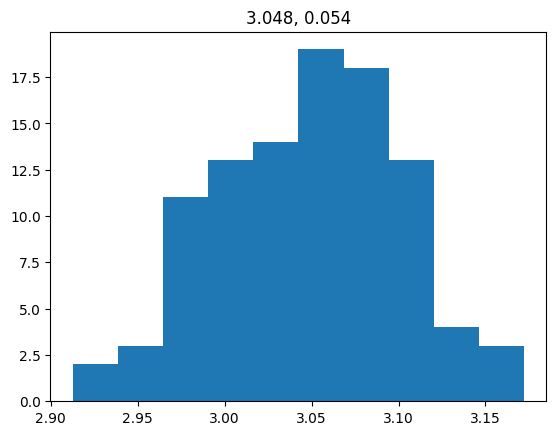

In [ ]:
plt.hist(np.array(res)[:, 0])
plt.title(f'{np.mean(np.array(res)[:, 0]):.3f}, {np.mean(np.array(res)[:, 1]):.3f}')
plt.show()

###### Experiments for Different DGPs

In [ ]:
np.random.seed(123)
true_params = {}
for mu1, mu2 in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    data = gen_opt(10000000, mu1, mu2)
    true_params[(mu1, mu2)] = np.mean(data[4])
    print(mu1, mu2, true_params[(mu1, mu2)])

0 0 -0.0008570689981499457
0 1 1.2002838919555336
1 0 1.0000452388167262
1 1 3.0487257846772864


In [ ]:
mlreg = lambda: RandomForestRegressor(max_depth=5, min_samples_leaf=50)

nexp = 100
res_dict = {}
for mu1, mu2 in [(0, 0), (0, 1), (1, 0), (1, 1)]:
    for n in [1000, 10000]:
        for alpha in [.15, .26, .75]:
            beta = n**alpha
            res = Parallel(n_jobs=-1, verbose=3)(delayed(exp)(it, n, mu1, mu2, phi1, phi2, beta=beta,
                                                   yreg1=mlreg, treg1=mlreg, yreg2=mlreg, treg2=mlreg) for it in range(nexp))
            res = np.array(res)
            if mu1 == 0 and mu2 == 0:
                true = 0
            else:
                true = true_params[(mu1, mu2)]
            res_dict[(mu1, mu2, n, alpha)] = res
            print(f'n={n}, beta=n^({alpha:.2f}), m1={mu1:.2f}, m2={mu2:.2f}, true={true:.3f}, \n',
                  f'\t cov={get_coverage(res, true):.2f}, '
                  f'bias={get_bias(res, true):.2f}, '
                  f'mean={np.mean(res[:, 0]):.2f}, '
                  f'std={get_std(res, true):.2f}, '
                  f'avg_stderr={get_mean_stderr(res, true):.2f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.15), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.94, bias=0.01, mean=-0.01, std=0.07, avg_stderr=0.06


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.26), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.91, bias=0.03, mean=0.03, std=0.07, avg_stderr=0.06


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.75), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.79, bias=0.09, mean=0.09, std=0.07, avg_stderr=0.07


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 11.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.15), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.95, bias=0.00, mean=-0.00, std=0.02, avg_stderr=0.02


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.26), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.95, bias=0.00, mean=0.00, std=0.02, avg_stderr=0.02


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.75), m1=0.00, m2=0.00, true=0.000, 
 	 cov=0.92, bias=0.03, mean=0.03, std=0.02, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.15), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.89, bias=0.01, mean=1.19, std=0.11, avg_stderr=0.09


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.26), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.90, bias=0.04, mean=1.24, std=0.11, avg_stderr=0.10


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.75), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.87, bias=0.08, mean=1.28, std=0.11, avg_stderr=0.10


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.15), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.92, bias=0.02, mean=1.18, std=0.03, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.26), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.94, bias=0.01, mean=1.21, std=0.03, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.75), m1=0.00, m2=1.00, true=1.200, 
 	 cov=0.95, bias=0.03, mean=1.23, std=0.03, avg_stderr=0.04


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   23.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.15), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.79, bias=0.09, mean=0.91, std=0.09, avg_stderr=0.08


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.26), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.90, bias=0.01, mean=0.99, std=0.09, avg_stderr=0.08


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.75), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.95, bias=0.02, mean=1.02, std=0.09, avg_stderr=0.08


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.15), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.82, bias=0.03, mean=0.97, std=0.03, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.26), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.97, bias=0.00, mean=1.00, std=0.03, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.75), m1=1.00, m2=0.00, true=1.000, 
 	 cov=0.96, bias=0.01, mean=1.01, std=0.03, avg_stderr=0.03


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.15), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.88, bias=0.03, mean=3.02, std=0.15, avg_stderr=0.12


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.26), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.90, bias=0.00, mean=3.05, std=0.14, avg_stderr=0.12


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   21.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=1000, beta=n^(0.75), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.91, bias=0.01, mean=3.06, std=0.14, avg_stderr=0.12


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.15), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.92, bias=0.00, mean=3.04, std=0.05, avg_stderr=0.04


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.5min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


n=10000, beta=n^(0.26), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.92, bias=0.01, mean=3.05, std=0.04, avg_stderr=0.04


[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:  2.9min


n=10000, beta=n^(0.75), m1=1.00, m2=1.00, true=3.049, 
 	 cov=0.92, bias=0.01, mean=3.06, std=0.04, avg_stderr=0.04


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 10.3min finished


In [ ]:
for confidence in [.9, .95]:
    df = {}
    for it, (mu1, mu2) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
        akey = f'$(\\alpha_1,\\alpha_2)=({mu1:.0f}, {mu2:.0f})$'
        df[akey] = {}
        for alpha in [.15, .26, .75]:
            bkey = '$\\beta=n^{' + f'{alpha:.2f}' + '}$'
            df[akey][bkey] = {}
            for n in [1000, 10000]:
                if mu1 == 0 and mu2 == 0:
                    true = 0
                else:
                    true = true_params[(mu1, mu2)]
                cov = get_coverage(res_dict[(mu1, mu2, n, alpha)], true, confidence)
                nexp = res_dict[(mu1, mu2, n, alpha)].shape[0]
                stderr = np.sqrt(cov * (1 - cov) / 100)
                df[akey][bkey][f'$n={n}$'] = f'${cov:.2f} \pm {stderr:.2f}$'
        df[akey] = pd.DataFrame(df[akey]).T

    df = pd.concat(df, axis=1)
    print(df.to_latex(escape=False, multicolumn=True))

\begin{tabular}{lllllllll}
\toprule
{} & \multicolumn{2}{l}{$(\alpha_1,\alpha_2)=(0, 0)$} & \multicolumn{2}{l}{$(\alpha_1,\alpha_2)=(0, 1)$} & \multicolumn{2}{l}{$(\alpha_1,\alpha_2)=(1, 0)$} & \multicolumn{2}{l}{$(\alpha_1,\alpha_2)=(1, 1)$} \\
{} &                     $n=1000$ &        $n=10000$ &                     $n=1000$ &        $n=10000$ &                     $n=1000$ &        $n=10000$ &                     $n=1000$ &        $n=10000$ \\
\midrule
$\beta=n^{0.15}$ &              $0.85 \pm 0.04$ &  $0.89 \pm 0.03$ &              $0.87 \pm 0.03$ &  $0.82 \pm 0.04$ &              $0.68 \pm 0.05$ &  $0.72 \pm 0.04$ &              $0.82 \pm 0.04$ &  $0.86 \pm 0.03$ \\
$\beta=n^{0.26}$ &              $0.83 \pm 0.04$ &  $0.88 \pm 0.03$ &              $0.82 \pm 0.04$ &  $0.89 \pm 0.03$ &              $0.88 \pm 0.03$ &  $0.88 \pm 0.03$ &              $0.81 \pm 0.04$ &  $0.86 \pm 0.03$ \\
$\beta=n^{0.75}$ &              $0.69 \pm 0.05$ &  $0.77 \pm 0.04$ &              $0.74 \pm 0.04$ &

<ipython-input-38-7c107cc5d15f>:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, multicolumn=True))
<ipython-input-38-7c107cc5d15f>:21: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, multicolumn=True))


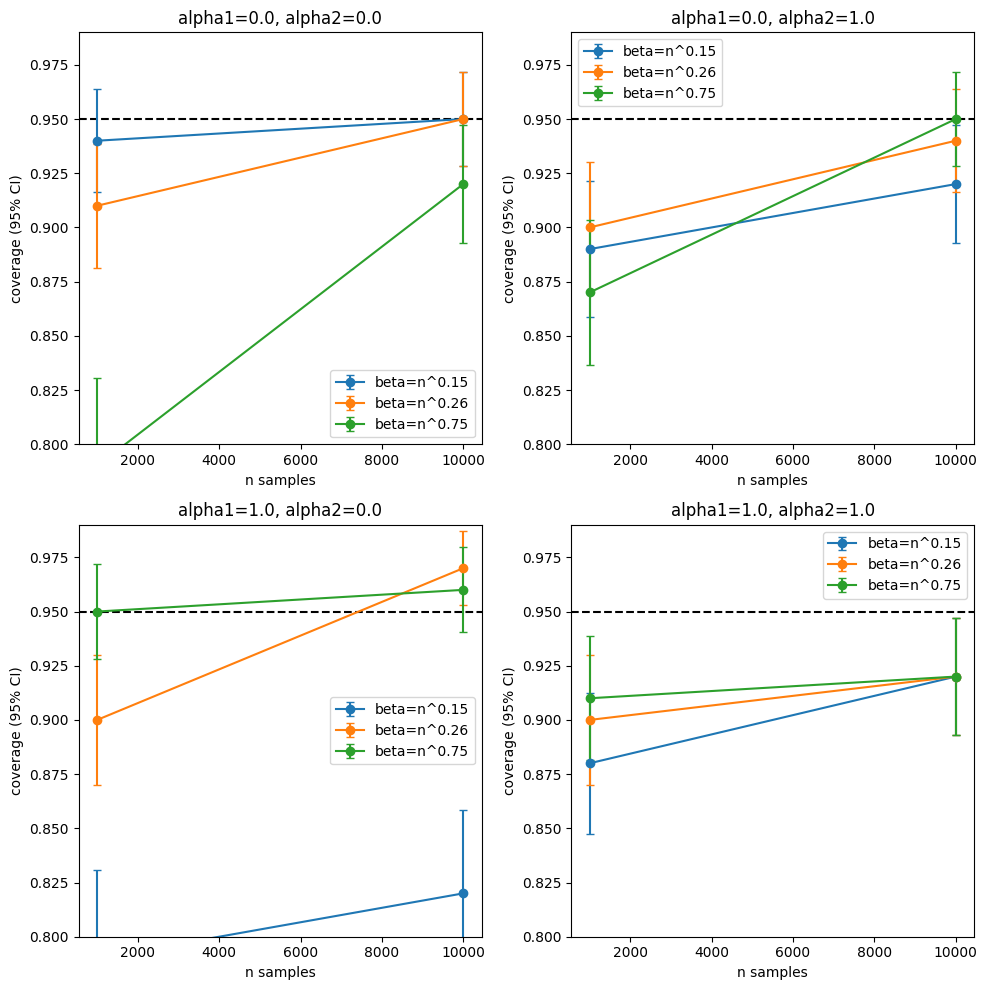

In [ ]:
plt.figure(figsize=(10, 10))
for it, (mu1, mu2) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    plt.subplot(2, 2, it + 1)
    plt.title(f'alpha1={mu1:.1f}, alpha2={mu2:.1f}')
    plt.axhline(y=0.95, color='black', linestyle='--')
    for alpha in [.15, .26, .75]:
        covs = []
        for n in [1000, 10000]:
            if mu1 == 0 and mu2 == 0:
                true = 0
            else:
                true = true_params[(mu1, mu2)]
            covs.append(get_coverage(res_dict[(mu1, mu2, n, alpha)], true))
        covs = np.array(covs)
        plt.errorbar([1000, 10000], covs, yerr=np.sqrt(covs * (1 - covs) / 100),
                     fmt='-o', capsize=3, label=f'beta=n^{alpha:.2f}')
    plt.xlabel('n samples')
    plt.ylabel('coverage (95% CI)')
    plt.ylim(.8, .99)
    plt.legend()
plt.tight_layout()
plt.savefig('coverage.png', dpi=600)
plt.show()

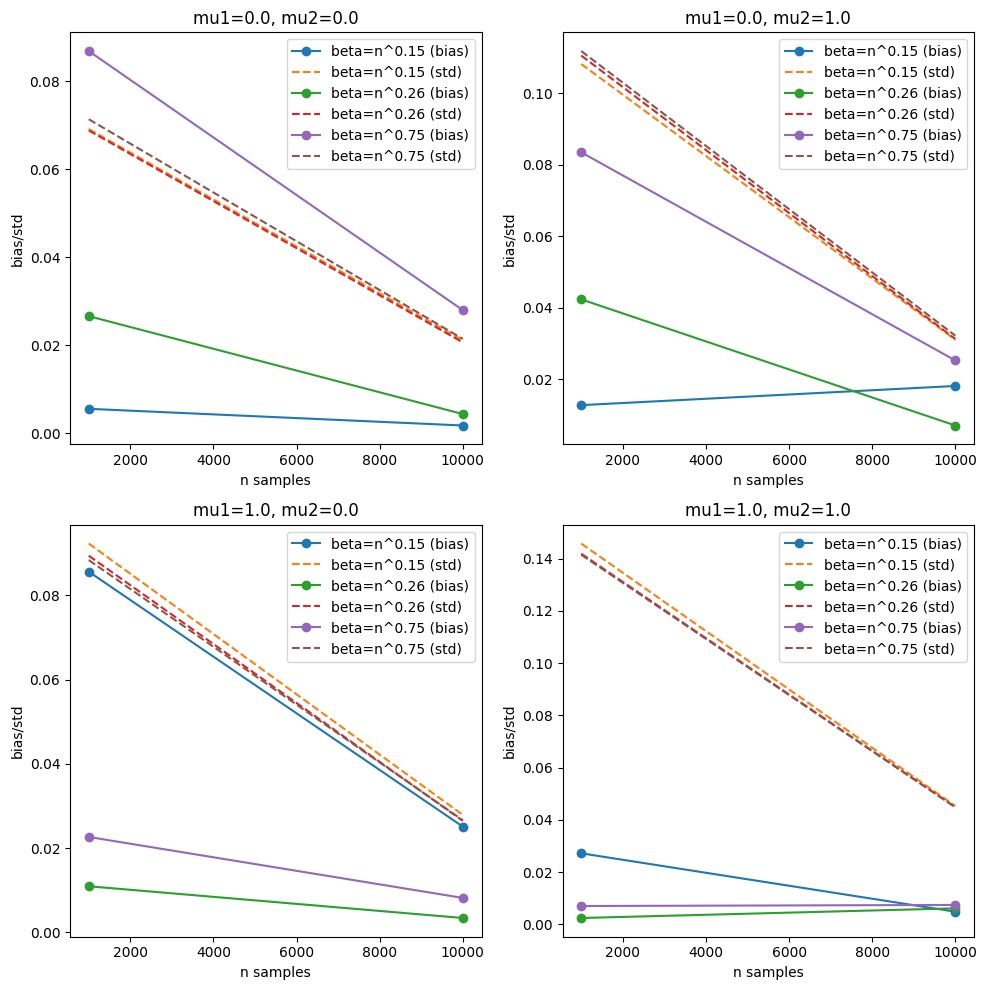

In [41]:
plt.figure(figsize=(10, 10))
for it, (mu1, mu2) in enumerate([(0, 0), (0, 1), (1, 0), (1, 1)]):
    plt.subplot(2, 2, it + 1)
    plt.title(f'mu1={mu1:.1f}, mu2={mu2:.1f}')
    for alpha in [.15, .26, .75]:
        biases = []
        stdes = []
        for n in [1000, 10000]:
            if mu1 == 0 and mu2 == 0:
                true = 0
            else:
                true = true_params[(mu1, mu2)]
            biases.append(get_bias(res_dict[(mu1, mu2, n, alpha)], true))
            stdes.append(get_std(res_dict[(mu1, mu2, n, alpha)], true))
        plt.plot([1000, 10000], biases, '-o', label=f'beta=n^{alpha:.2f} (bias)')
        plt.plot([1000, 10000], stdes, '--',  label=f'beta=n^{alpha:.2f} (std)')
    plt.xlabel('n samples')
    plt.ylabel('bias/std')
    plt.legend()
plt.tight_layout()
plt.show()